# Data Preprocessing & Training the CNN Model

0
1
(964, 32, 32, 3)


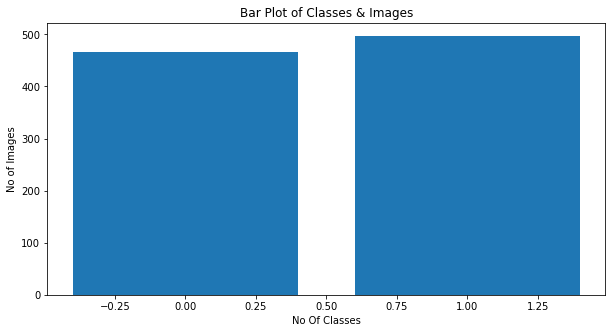

Epoch 1/10
19/19 [==============================] - 7s 260ms/step - loss: 0.6950 - accuracy: 0.5131 - val_loss: 0.6857 - val_accuracy: 0.4959
Epoch 2/10
19/19 [==============================] - 5s 247ms/step - loss: 0.6834 - accuracy: 0.5656 - val_loss: 0.6611 - val_accuracy: 0.7479
Epoch 3/10
19/19 [==============================] - 7s 354ms/step - loss: 0.6565 - accuracy: 0.6346 - val_loss: 0.6286 - val_accuracy: 0.7438
Epoch 4/10
19/19 [==============================] - 7s 369ms/step - loss: 0.6196 - accuracy: 0.6652 - val_loss: 0.5242 - val_accuracy: 0.7975
Epoch 5/10
19/19 [==============================] - 7s 379ms/step - loss: 0.5560 - accuracy: 0.7298 - val_loss: 0.4662 - val_accuracy: 0.8182
Epoch 6/10
19/19 [==============================] - 5s 254ms/step - loss: 0.4997 - accuracy: 0.7737 - val_loss: 0.3893 - val_accuracy: 0.8264
Epoch 7/10
19/19 [==============================] - 4s 234ms/step - loss: 0.4576 - accuracy: 0.7987 - val_loss: 0.3571 - val_accuracy: 0.8719
Epoch 

In [12]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Dropout, Flatten
from keras.optimizers import Adam
########################################


path='/home/iiit/Desktop/face_mask_detection/dataset'
images=[]
classNo=[]
testRatio=0.2
valRatio=0.2
imgDimension=(32,32,3)

#########################################

myList=os.listdir(path)

numOfClasses=len(myList)

#print(numOfClasses)

#print("Importing Classes..........")
for x in range(0, numOfClasses):
	myPicList=os.listdir(path+"/"+str(x))
	# myData/0/img.jpg
	for y in myPicList:
		curImg=cv2.imread(path+"/"+str(x)+"/"+y)
		curImg=cv2.resize(curImg,(imgDimension[0],imgDimension[1]))
		images.append(curImg)
		classNo.append(x)
	print(x)

images=np.array(images)
classNo=np.array(classNo)

#########Spliting The Data###########

x_train, x_test, y_train, y_test=train_test_split(images, classNo, test_size=testRatio)
x_train, x_validation, y_train, y_validation=train_test_split(x_train, y_train, test_size=valRatio)

print(x_train.shape)

numOfSample=[]

for x in range(0,numOfClasses):
	numOfSample.append(len(np.where(y_train==x)[0]))


plt.figure(figsize=(10,5))
plt.bar(range(0, numOfClasses),numOfSample)
plt.title("Bar Plot of Classes & Images")
plt.xlabel("No Of Classes")
plt.ylabel("No of Images")
plt.show()

def preprocessing(img):
	# img=np.astype("uint8")
	img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	img=cv2.equalizeHist(img)
	img=img/255
	return img

x_train=np.array(list(map(preprocessing, x_train)))
x_test=np.array(list(map(preprocessing, x_test)))
x_validation=np.array(list(map(preprocessing, x_validation)))


x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2],1)
x_test=x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
x_validation=x_validation.reshape(x_validation.shape[0], x_validation.shape[1], x_validation.shape[2],1)


dataGen=ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10)

dataGen.fit(x_train)

y_train=to_categorical(y_train, numOfClasses)
y_test=to_categorical(y_test, numOfClasses)
y_validation=to_categorical(y_validation, numOfClasses)


def myModel():
	sizeOfFilter1=(3,3)
	sizeOfFilter2=(3,3)
	sizeOfPool=(2,2)

	model=Sequential()
	model.add((Conv2D(32, sizeOfFilter1, input_shape=(imgDimension[0],imgDimension[1],1),activation='relu')))
	model.add((Conv2D(32, sizeOfFilter1,activation='relu')))
	model.add(MaxPooling2D(pool_size=sizeOfPool))

	model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
	model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
	model.add(MaxPooling2D(pool_size=sizeOfPool))
	model.add(Dropout(0.5))


	model.add(Flatten())
	model.add(Dense(64, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(numOfClasses, activation='softmax'))
	model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
	return model

model=myModel()
#print(model.summary())
batch_size = 50
history=model.fit_generator(dataGen.flow(x_train, y_train,batch_size),
	steps_per_epoch=len(x_train)//batch_size,
	epochs=10,
	validation_data=(x_validation,y_validation),
	shuffle=1)

model.save("MyTrainingModel.h5")